In [1]:
import sys
import pandas as pd
import numpy as np
import json
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from itertools import product, groupby, chain, compress
from scipy.stats import ttest_ind, pearsonr, hmean
from sklearn import metrics as mtr
from datetime import datetime
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage, AnnotationBbox, AnchoredText)
import warnings


warnings.filterwarnings("ignore")

In [2]:
def parse_fasta(fasta):
    with open(fasta) as f:
        faiter = (x[1] for x in groupby(f, lambda line: line.startswith(">")))
        for header in faiter:
            yield next(header)[1:].strip(), "".join(s.strip() for s in next(faiter))

In [3]:
def names(fname):
    names = json.load(open(datadir / "caid_names.json"))

    name = names.get(fname)
    if name is None:
        fname = fname.lower()
        if "cons" in fname:
            name = "Conservation"
        elif "pdb" in fname and 'reverse' in fname:
            name = "PDB observed"
        elif "gene3d" in fname and 'reverse' in fname:
            name = "Gene3D"
        elif "remote20-30" in fname:
            name = "PDB Remote"
        elif "remote30-100" in fname:
            name = "PDB Close"
        elif "random" in fname:
            name = "Random"
        elif "dataset" in fname:
            name = "Shuffled dataset"
        elif "target" in fname:
            name = "Shuffled targets"
        elif "fix" in fname:
            name = "Fixed ID content"
        elif "ref" in fname:
            name = "Reference"
    return name
    

In [4]:
dataset_names = {
    'disprot-disorder': 'DisProt',
    'disprot-disorder-pdb-atleast': 'DisProt-PDB',
    'disprot-binding': 'DisProt-Binding',
    'disprot-binding-all': 'DisProt-Binding-All',
    'disprot-binding-disorder': 'DisProt-Binding-Disorder'
}

In [5]:
# From the lab
# caidfolder = Path("/mnt/sshfs/urano/home/dampiove/CAID/")
# datadir = Path("/mnt/sshfs/urano/home/dampiove/CAID/data/")


# From lempo
caidfolder = Path("/home/damiano/Projects/CAID-alphafold/")
datadir = Path("/home/damiano/Projects/CAID-alphafold/data/")

## Display element 2 - F1-Score and Precision Recall Curves


In [6]:
from scipy import stats

def confidence_interval(series, interval=0.95):
    mean = series.mean()
    n = series.count()
    test_stat = stats.t.ppf((interval + 1)/2, n)
    norm_test_stat = (test_stat * series.std()) / (n ** 0.5)
    lower_bound = mean - norm_test_stat
    upper_bound = mean + norm_test_stat
    return upper_bound - lower_bound

In [7]:
def merge_pred_base_metrics_dataset(dataset, excluded_methods, thr_opt):
    metrics_dataset_preds = pd.read_csv(datadir / "results/{}.analysis.all.dataset.{}.metrics.csv".format(dataset, thr_opt), index_col=[0])
    metrics_dataset_npdbr = pd.read_csv(datadir / "results/{}.naive-pdb-atleast-reverse.all.dataset.{}.metrics.csv".format(dataset, thr_opt), index_col=[0])
    metrics_dataset_pdbr30 = pd.read_csv(datadir / "results/{}.naive-pdb-remote20-30-from-any-to-any.all.dataset.{}.metrics.csv".format(dataset, thr_opt), index_col=[0])
    metrics_dataset_pdbr30100 = pd.read_csv(datadir / "results/{}.naive-pdb-remote30-100-from-any-to-2018-11-30.all.dataset.{}.metrics.csv".format(dataset, thr_opt), index_col=[0])
    metrics_dataset_ngen3 = pd.read_csv(datadir / "results/{}.naive-gene3d-reverse.all.dataset.{}.metrics.csv".format(dataset, thr_opt), index_col=[0])
    metrics_dataset_nfixf = pd.read_csv(datadir / "results/{}.fixedposfrc.all.dataset.{}.metrics.csv".format(dataset, thr_opt), index_col=[0])
    metrics_dataset_randm = pd.read_csv(datadir / "results/{}.random.all.dataset.{}.metrics.csv".format(dataset, thr_opt), index_col=[0])
    metrics_dataset_shudt = pd.read_csv(datadir / "results/{}.shuffledataset.all.dataset.{}.metrics.csv".format(dataset, thr_opt), index_col=[0])
    metrics_dataset_cons = pd.read_csv(datadir / "results/{}.cons.all.dataset.{}.metrics.csv".format(dataset, thr_opt), index_col=[0])
    
    mtr_dataset_preds = metrics_dataset_preds.rename(names).drop(excluded_methods, errors='ignore')
    
    mtr_dataset_base = metrics_dataset_ngen3.rename(names)\
        .append(metrics_dataset_npdbr\
        .append(metrics_dataset_pdbr30)\
        .append(metrics_dataset_pdbr30100)\
        .append(metrics_dataset_cons)\
                .rename(names))
    
    return mtr_dataset_preds, mtr_dataset_base

In [8]:
def merge_pred_base_metrics_target(dataset, excluded_methods, thr_opt):
    metrics_target_preds = pd.read_csv(datadir / "results/{}.analysis.all.target.{}.metrics.csv".format(dataset, thr_opt), index_col=[0, 1])
    metrics_target_npdbr = pd.read_csv(datadir / "results/{}.naive-pdb-atleast-reverse.all.target.{}.metrics.csv".format(dataset, thr_opt), index_col=[0, 1])
    metrics_target_pdbr30 = pd.read_csv(datadir / "results/{}.naive-pdb-remote20-30-from-any-to-any.all.target.{}.metrics.csv".format(dataset, thr_opt), index_col=[0, 1])
    metrics_target_pdbr30100 = pd.read_csv(datadir / "results/{}.naive-pdb-remote30-100-from-any-to-2018-11-30.all.target.{}.metrics.csv".format(dataset, thr_opt), index_col=[0, 1])
    metrics_target_ngen3 = pd.read_csv(datadir / "results/{}.naive-gene3d-reverse.all.target.{}.metrics.csv".format(dataset, thr_opt), index_col=[0, 1])
    metrics_target_cons = pd.read_csv(datadir / "results/{}.cons.all.target.{}.metrics.csv".format(dataset, thr_opt), index_col=[0, 1])
    
    return metrics_target_preds.rename(names, axis=0, level=0).drop(excluded_methods, errors='ignore'), pd.concat([metrics_target_npdbr, metrics_target_pdbr30, metrics_target_pdbr30100, metrics_target_ngen3, metrics_target_cons], axis=0).rename(names, axis=0, level=0)

def get_bar_data_target(dataset, excluded_methods, first=10, mtr='f1s'):
    metrics_target_preds = pd.read_csv(datadir / "results/{}.analysis.all.target.{}.metrics.csv".format(dataset, mtr), index_col=[0, 1])
    metrics_target_npdbr = pd.read_csv(datadir / "results/{}.naive-pdb-atleast-reverse.all.target.{}.metrics.csv".format(dataset, mtr), index_col=[0, 1])
    metrics_target_pdbr30 = pd.read_csv(datadir / "results/{}.naive-pdb-remote20-30-from-any-to-any.all.target.{}.metrics.csv".format(dataset, mtr), index_col=[0, 1])
    metrics_target_pdbr30100 = pd.read_csv(datadir / "results/{}.naive-pdb-remote30-100-from-any-to-2018-11-30.all.target.{}.metrics.csv".format(dataset, mtr), index_col=[0, 1])
    
    metrics_target_ngen3 = pd.read_csv(datadir / "results/{}.naive-gene3d-reverse.all.target.{}.metrics.csv".format(dataset, mtr), index_col=[0, 1])
    metrics_target_cons = pd.read_csv(datadir / "results/{}.cons.all.target.{}.metrics.csv".format(dataset, mtr), index_col=[0, 1])
#     metrics_target_nfixf = pd.read_csv(datadir / "results/{}.fixedposfrc.all.target.{}.metrics.csv".format(dataset, mtr), index_col=[0, 1])
#     metrics_target_idcnt = pd.read_csv(datadir / "results/{}.shuffletargets.all.target.{}.metrics.csv".format(dataset, mtr), index_col=[0, 1])
    
    mtr_target_preds = metrics_target_preds[mtr].groupby(level=0).describe()[["mean", "std"]].sort_values("mean",ascending=False)
    mtr_target_base = pd.concat(
        [metrics_target_ngen3[mtr].describe()[["mean", "std"]].to_frame().T.rename({mtr: "Naive Gene3D"}),
         metrics_target_npdbr[mtr].describe()[["mean", "std"]].to_frame().T.rename({mtr: "Naive PDB"}),
         metrics_target_pdbr30[mtr].describe()[["mean", "std"]].to_frame().T.rename({mtr: "Naive PDB-Remote 20-30"}),
         metrics_target_pdbr30100[mtr].describe()[["mean", "std"]].to_frame().T.rename({mtr: "Naive PDB-Remote 30-100"}),
         metrics_target_cons[mtr].describe()[["mean", "std"]].to_frame().T.rename({mtr: "Naive Conservation"}),
#          metrics_target_idcnt[mtr].describe()[["mean", "std"]].to_frame().T.rename({mtr: "Shuffled Targets"})
        ],
        sort=False).sort_values("mean", ascending=False)
    
    mtr_target = mtr_target_preds.rename(names).drop(excluded_methods).head(10).append(mtr_target_base)
    mtr_target['std'] = mtr_target['std'] / len(metrics_target_preds.index.get_level_values(1).unique()) ** 0.5
    return mtr_target.rename({'mean':'y', 'std':'err'}, axis=1), mtr_target_base['mean'].max()

In [9]:
def get_auc_data(dataset, excluded_methods):
    pauc = pd.DataFrame.from_records(pd.read_csv(datadir / "results/{}.analysis.all.dataset._.roc.csv".format(dataset),
                                          index_col=[0], 
                                          header=[0,1,2]).columns.droplevel(2).tolist(), columns=['method', 'y']
                             ).set_index('method').rename(names).astype(float).sort_values('y', ascending=False).assign(err=0)
    pauc = pauc.loc[~pauc.index.duplicated(keep='first')].drop(excluded_methods).head(10)
    cauc = pd.DataFrame.from_records(pd.read_csv(datadir / "results/{}.cons.all.dataset._.roc.csv".format(dataset),
                                          index_col=[0],
                                          header=[0,1,2]).columns.droplevel(2).tolist(), columns=['method', 'y']
                             ).set_index('method').rename(names).astype(float).sort_values('y', ascending=False).assign(err=0)
    cauc = cauc.loc[~cauc.index.duplicated(keep='first')]
    gauc = pd.DataFrame.from_records(pd.read_csv(datadir / "results/{}.naive-gene3d-reverse.all.dataset._.roc.csv".format(dataset),
                                          index_col=[0],
                                          header=[0,1,2]).columns.droplevel(2).tolist(), columns=['method', 'y']
                             ).set_index('method').rename(names).astype(float).sort_values('y', ascending=False).assign(err=0)
    gauc = gauc.loc[~gauc.index.duplicated(keep='first')]
    
    pdbauc = pd.DataFrame.from_records(pd.read_csv(datadir / "results/{}.naive-pdb-atleast-reverse.all.dataset._.roc.csv".format(dataset),
                                          index_col=[0],
                                          header=[0,1,2]).columns.droplevel(2).tolist(), columns=['method', 'y']
                             ).set_index('method').rename(names).astype(float).sort_values('y', ascending=False).assign(err=0)
    pdbauc = pdbauc.loc[~pdbauc.index.duplicated(keep='first')]
    pdbr2030auc = pd.DataFrame.from_records(pd.read_csv(datadir / "results/{}.naive-pdb-remote20-30-from-any-to-any.all.dataset._.roc.csv".format(dataset),
                                          index_col=[0],
                                          header=[0,1,2]).columns.droplevel(2).tolist(), columns=['method', 'y']
                             ).set_index('method').rename(names).astype(float).sort_values('y', ascending=False).assign(err=0)
    pdbr2030auc = pdbr2030auc.loc[~pdbr2030auc.index.duplicated(keep='first')]
    pdbr30100auc = pd.DataFrame.from_records(pd.read_csv(datadir / "results/{}.naive-pdb-remote30-100-from-any-to-2018-11-30.all.dataset._.roc.csv".format(dataset),
                                          index_col=[0],
                                          header=[0,1,2]).columns.droplevel(2).tolist(), columns=['method', 'y']
                             ).set_index('method').rename(names).astype(float).sort_values('y', ascending=False).assign(err=0)
    pdbr30100auc = pdbr30100auc.loc[~pdbr30100auc.index.duplicated(keep='first')]
    
    
    bauc = cauc.append(gauc).append(pdbauc).append(pdbr2030auc).append(pdbr30100auc)
    bauc.loc[names('random')] = [0.5, 0]
    bauc.loc[names('shuffledataset')] = [0.5, 0]
    
    return pauc.append(bauc.sort_values('y', ascending=False)), bauc.values.max()


In [10]:
def plot_roc(ax, dataset, excluded_methods, plotlbl, colormap=None):
    colormap = colormap if colormap is not None else dict()
    procs = pd.read_csv(datadir / "results/{}.analysis.all.dataset._.roc.csv".format(dataset), index_col=[0], header=[0,1,2]).rename(names, axis=1, level=0)\
    .drop(excluded_methods, axis=1, level=0, errors='ignore')
    proc = pd.read_csv(datadir / "results/{}.naive-pdb-atleast-reverse.all.dataset._.roc.csv".format(dataset), index_col=[0], header=[0,1,2])
    pr2030roc = pd.read_csv(datadir / "results/{}.naive-pdb-remote20-30-from-any-to-any.all.dataset._.roc.csv".format(dataset), index_col=[0], header=[0,1,2])
    pr30100roc = pd.read_csv(datadir / "results/{}.naive-pdb-remote30-100-from-any-to-2018-11-30.all.dataset._.roc.csv".format(dataset), index_col=[0], header=[0,1,2])
    groc = pd.read_csv(datadir / "results/{}.naive-gene3d-reverse.all.dataset._.roc.csv".format(dataset), index_col=[0], header=[0,1,2])
    croc = pd.read_csv(datadir / "results/{}.cons.all.dataset._.roc.csv".format(dataset), index_col=[0], header=[0,1,2])
    
    cov = pd.read_csv(datadir / 'results/{}.analysis.all.target.default.metrics.csv'.format(dataset), index_col=[0,1], header=[0,1])
    cov = (cov.groupby(level=0).count().max(axis=1) / np.max(cov.groupby(level=0).count().values))
    
        # plot f-score level lines
    r = np.linspace(0, 1, 1000)
    fs = np.mean(np.array(np.meshgrid(r, r)).T.reshape(-1, 2), axis=1).reshape(1000, 1000)
    cs = ax.contour(r[::-1], r, fs, levels=np.linspace(0.1, 1, 10), colors='silver', alpha=0.7, linewidths=1, linestyles='--')
    ax.clabel(cs, inline=True, fmt='%.1f', fontsize=10, manual=[(l, 1-l) for l in cs.levels[:-1]])
    
    
    # Add always alphafold by default
    auc_rocs = sorted(procs.columns.droplevel(2).unique(), key=lambda t: t[1], reverse=True)
    auc_af = [(k, v) for (k, v) in auc_rocs if 'alphafold' in k.lower()]
    for t in auc_af:
        auc_rocs.remove(t)
    auc_rocs = sorted(auc_rocs[:8] + auc_af, key=lambda t: t[1], reverse=True)
    
    
    rocs = procs.reindex(list(zip(*auc_rocs))[0], axis=1, level=0)

    for p in rocs.columns.get_level_values(0).unique()[:10]:
        if 'alphafold' in p.lower():
            z = 100
            lw=2
        else:
            z = 1
            lw=1
        lines = ax.plot(*rocs[p].dropna().T.values, label=p, color=colormap.get(p), lw=lw, zorder=z)
    
    # Conservation
    ax.plot(*croc.values.T, label="Naive Conservation", color='k', linewidth=1)
    cov['Naive Conservation'] = 1

    # PDB baselines
    for n, m in zip([proc, groc, pr2030roc, pr30100roc], ['o', 's', 'D', 'd']):
        idx = n.index.values - 0.5
        ax.plot(*n.loc[1.0], marker=m, markeredgecolor='k', markeredgewidth=1, markerfacecolor='w', markersize=8, 
                     c='w', label=names(n.columns.get_level_values(0)[0]))

    # Random baselines
    for b, m in zip(['random', 'shuffledataset'], ['x', 'X', 'd']):
        ax.plot(*pd.read_csv(datadir / 'results/{}.{}.all.target.mcc.metrics.csv'.format(dataset, b), index_col=0)[['fpr', 'tpr']].mean(), 
                     marker=m, markeredgecolor='k', markeredgewidth=1, markerfacecolor='w', markersize=8, 
                     c='w', label=names(b))
    
    # Legend
    cov = cov.rename(names).round(2).to_dict()
    ax.legend()
    lhandles, llabels = ax.get_legend_handles_labels()
    auc_rocs.extend(croc.rename(names, axis=1, level=0).columns.droplevel(2).unique().tolist())
    
    pwauc = next(zip(*auc_rocs))
    ax.legend(lhandles, ['{}'.format('{} (A={}, C={})'.format(l, auc_rocs[pwauc.index(l)][1], cov[l]) if l in pwauc else l) for l in llabels],
            loc='upper left', bbox_to_anchor=(1, 1))#, ncol=2, mode="expand", borderaxespad=0., fontsize=9.4)
    
    ax.text(-0.15, 1.05, plotlbl, transform=ax.transAxes, size=13, weight='bold')
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    # ax.set_xlim(-0.05, .4)
    # ax.set_ylim(-0.05, .4)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    
# fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
# plot_pred_and_bases_rocs(axes[0], roc_simple_preds, roc_simple_npdbr, roc_simple_ngen3, 'disprot-disorder', 'DisProt', names, roc_simple_ncons)
# plot_pred_and_bases_rocs(axes[1], roc_pdb_preds, roc_pdb_npdbr, roc_pdb_ngen3, 'disprot-disorder-pdb-atleast', 'DisProt-PDB', names, roc_pdb_ncons)
# plt.savefig("../manuscript/fig3.png", dpi=300, bbox_inches="tight")

In [11]:
def plot_pr(ax, dataset, excluded_methods, plotlbl='C', colormap=None):
    colormap = colormap if colormap is not None else dict()
    pred_prs = pd.read_csv(datadir / "results/{}.analysis.all.dataset._.pr.csv".format(dataset), index_col=[0], header=[0, 1, 2, 3]).rename(names, axis=1, level=0)\
    .drop(excluded_methods, axis=1, level=0, errors='ignore')
    pdb_prc = pd.read_csv(datadir / "results/{}.naive-pdb-atleast-reverse.all.dataset._.pr.csv".format(dataset), index_col=[0], header=[0, 1, 2, 3])
    pdb_pr2030rc = pd.read_csv(datadir / "results/{}.naive-pdb-remote20-30-from-any-to-any.all.dataset._.pr.csv".format(dataset), index_col=[0], header=[0, 1, 2, 3])
    pdb_pr30100rc = pd.read_csv(datadir / "results/{}.naive-pdb-remote30-100-from-any-to-2018-11-30.all.dataset._.pr.csv".format(dataset), index_col=[0], header=[0, 1, 2, 3])
    gene3d_prc = pd.read_csv(datadir / "results/{}.naive-gene3d-reverse.all.dataset._.pr.csv".format(dataset), index_col=[0], header=[0, 1, 2, 3])
    cons_prc = pd.read_csv(datadir / 'results/{}.cons.all.dataset._.pr.csv'.format(dataset), index_col=[0], header=[0, 1, 2, 3])
    random_prcs = [pd.read_csv(datadir / 'results/{}.{}.all.target.mcc.metrics.csv'.format(dataset, b), index_col=0)
                        for b in ["random", "shuffledataset"]]

    cov = pd.read_csv(datadir / 'results/{}.analysis.all.target.default.metrics.csv'.format(dataset), index_col=[0,1], header=[0,1])
    cov = (cov.groupby(level=0).count().max(axis=1) / np.max(cov.groupby(level=0).count().values))

    sorter = sorted(((p, hmean(pred_prs[p].dropna().values, axis=1).max().round(2)) for p in pred_prs.columns.get_level_values(0).unique()),
                     key=lambda t: t[1], reverse=True)
    
    
    # Sort predictors (based on AUC)
    prcs = pred_prs.reindex(list(zip(*sorter))[0], axis=1, level=0)
        
    # Add always alphafold by default
    top_prcs = list(prcs.columns.get_level_values(0).unique())
    prcs_af = [k for k in top_prcs if 'alphafold' in k.lower()]
    for t in prcs_af:
        top_prcs.remove(t)
    top_prcs = top_prcs[:8] + prcs_af
    
    
    # plot f-score level lines
    r = np.linspace(0, 1, 1000)
    fs = hmean(np.array(np.meshgrid(r, r)).T.reshape(-1, 2), axis=1).reshape(1000, 1000)
    cs = ax.contour(r, r, fs, levels=np.linspace(0.1, 1, 10), colors='silver', alpha=0.7, linewidths=1, linestyles='--')
    ax.clabel(cs, inline=True, fmt='%.1f', fontsize=10, manual=[(l, l) for l in cs.levels[:-1]])

    # plot predictor lines and markers    
    for p, z in zip(top_prcs, range(5, 55, 5)):
        lw = 1
        if 'alphafold' in p.lower():
            z = 0
            lw = 2
        fmax_idx = hmean(prcs[p].dropna().T).argmax()
        lines = ax.plot(*prcs[p].dropna().T.values, label=p, zorder=55-z, lw=lw, color=colormap.get(p))
        ax.plot(*prcs[p].dropna().T.values[:, fmax_idx], color='w', marker='o', markerfacecolor=lines[0].get_color(), markersize=10, zorder=55-z)
        ax.plot(*prcs[p].dropna().T.values[:, fmax_idx], color='w', marker='o', markerfacecolor=lines[0].get_color(), zorder=55-z)

    # plot naive conservation
    ax.plot(*cons_prc.dropna().T.values, label="Naive Conservation", color='k', linewidth=1, zorder=5)
    cov['Naive Conservation'] = 1

    # plot naives
    for n, m in zip([pdb_prc, gene3d_prc, pdb_pr2030rc, pdb_pr30100rc], ['o', 's', 'D', 'd']):
        nname = n.columns.get_level_values(0)[0]
        cov[nname] = 1
        ax.plot(*n.loc[1.0], marker=m, markeredgecolor='k', markeredgewidth=1,
                markerfacecolor='w', markersize=8, zorder=60,
                c='w', label=names(nname))

    # plot randoms
    for rprc, m in zip(random_prcs, ['x', 'X', 'd']):
        rname = rprc.index.get_level_values(0)[0]
        cov[rname] = 1
        ax.plot(*rprc[['tpr', 'ppv']].mean(), marker=m, markeredgecolor='k', markeredgewidth=1, zorder=60,
                markerfacecolor='w', markersize=8, c='w', label=names(rname))

    cov = cov.rename(names).to_dict()
    ax.legend()
    lhandles, llabels = ax.get_legend_handles_labels()
    
    sorter.extend(cons_prc.rename(names, axis=1, level=0).columns.droplevel(2).unique().tolist())
    pwauc = next(zip(*sorter))
    ax.legend(lhandles,
              ['{}'.format('{} (F={}, C={:.2f})'.format(l, sorter[pwauc.index(l)][1], cov[l]) if l in pwauc else l) for l in llabels],
              loc='upper left', bbox_to_anchor=(1, 1))#, mode="expand", borderaxespad=0)
    
    ax.text(-0.15, 1.05, plotlbl, transform=ax.transAxes, size=13, weight='bold')
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")

## Figure 1 - Precision-Recall and AUC curves
Precision-Recall and ROC curves of the best 10 ranking methods (ranking is based on Fmax and ROC AUC respectively) and baselines.



In [12]:
excluded_methods_disorder = ["*SPOT-Disorder1", "IUPred-long", "IUPred-short", "*S2D-1", "ANCHOR", "AlphaFold-RSA_"]
excluded_methods_binding = ["AF_rsa-25", "AF_pLDDT"]

In [13]:
# Method names
preds_disorder = list(pd.read_csv(datadir / "results/disprot-disorder.analysis.all.dataset._.pr.csv", index_col=[0], header=[0, 1, 2, 3]).rename(names, axis=1, level=0).columns.get_level_values(0).unique().drop(excluded_methods_disorder, errors="ignore"))
preds_binding = list(pd.read_csv(datadir / "results/disprot-binding-all.analysis.all.dataset._.pr.csv", index_col=[0], header=[0, 1, 2, 3]).rename(names, axis=1, level=0).columns.get_level_values(0).unique().drop(excluded_methods_binding, errors="ignore"))
preds = preds_disorder + preds_binding

In [15]:
# All gray excpet AlphaFold
colormap = dict((p, (0.7803921568627451, 0.7803921568627451, 0.7803921568627451)) for i, p in enumerate(sorted(preds)))
colormap['AlphaFold-Bind'] = (0.5803921568627451, 0.403921568627451, 0.7411764705882353)
colormap['AlphaFold-RSA'] = (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
colormap['AlphaFold-pLDDT'] = (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

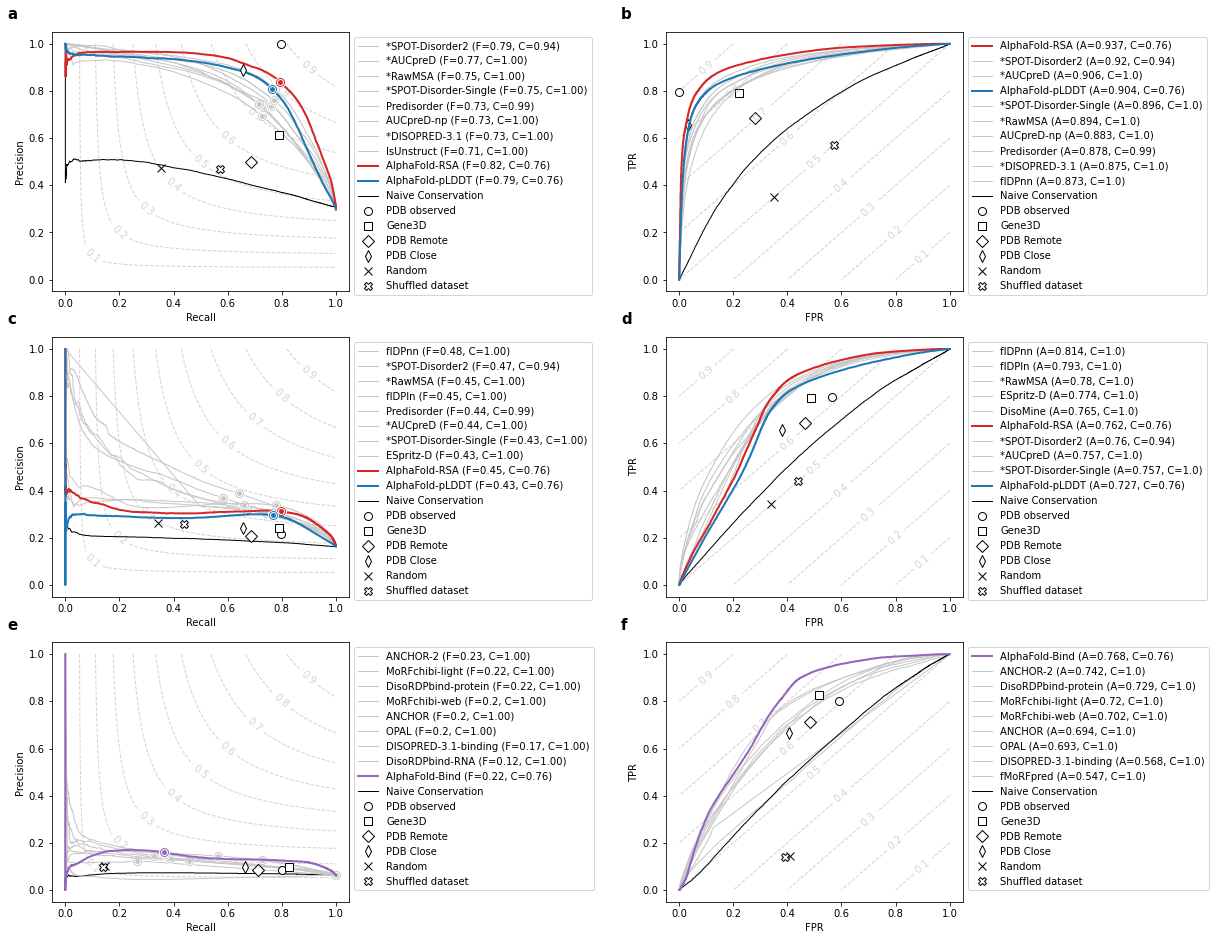

In [17]:
fig = plt.figure(figsize=(20, 16), constrained_layout=False)
gs = fig.add_gridspec(12, 6, wspace=1.2, hspace=1.5)

ax1 = fig.add_subplot(gs[0:4, :2])
ax2 = fig.add_subplot(gs[0:4, 3:-1])

ax3 = fig.add_subplot(gs[4:8, :2])
ax4 = fig.add_subplot(gs[4:8, 3:-1])

ax5 = fig.add_subplot(gs[8:, :2])
ax6 = fig.add_subplot(gs[8:, 3:-1])


ax1.text(-0.15, 1.05, 'a', transform=ax1.transAxes, size=15, weight='bold')
ax2.text(-0.15, 1.05, 'b', transform=ax2.transAxes, size=15, weight='bold')
ax3.text(-0.15, 1.05, 'c', transform=ax3.transAxes, size=15, weight='bold')
ax4.text(-0.15, 1.05, 'd', transform=ax4.transAxes, size=15, weight='bold')
ax5.text(-0.15, 1.05, 'e', transform=ax5.transAxes, size=15, weight='bold')
ax6.text(-0.15, 1.05, 'f', transform=ax6.transAxes, size=15, weight='bold')


plot_pr(ax1, 'disprot-disorder-pdb-atleast', excluded_methods_disorder, '', colormap)
plot_roc(ax2, 'disprot-disorder-pdb-atleast', excluded_methods_disorder, '', colormap)

plot_pr(ax3, 'disprot-disorder', excluded_methods_disorder, '', colormap)
plot_roc(ax4, 'disprot-disorder', excluded_methods_disorder, '', colormap)

plot_pr(ax5, 'disprot-binding-all', excluded_methods_binding, '', colormap)
plot_roc(ax6, 'disprot-binding-all', excluded_methods_binding, '', colormap)

plt.savefig(datadir / "manuscript/fig1.png", dpi=600, bbox_inches='tight')

## Display element 4 - Fully ID table
Performance of predictors (shown as confusion matrix) on their ability to discriminate fully disordered proteins (>95% id content) from non-fully disordered proteins.

In [18]:
predictions = pd.read_csv(datadir / "results/disprot-disorder.analysis.all.dataset._.predictions.csv", index_col=[0,1], header=[0,1])
baseline_cons = pd.read_csv(datadir / "results/disprot-disorder.cons.all.dataset._.predictions.csv", index_col=[0,1], header=[0,1])
baseline_pdbr = pd.read_csv(datadir / "results/disprot-disorder.naive-pdb-atleast-reverse.all.dataset._.predictions.csv", index_col=[0,1], header=[0,1])
baseline_pdbr2030 = pd.read_csv(datadir / "results/disprot-disorder.naive-pdb-remote20-30-from-any-to-any.all.dataset._.predictions.csv", index_col=[0,1], header=[0,1])
baseline_pdbr30100 = pd.read_csv(datadir / "results/disprot-disorder.naive-pdb-remote30-100-from-any-to-2018-11-30.all.dataset._.predictions.csv", index_col=[0,1], header=[0,1])
baseline_gene3dr = pd.read_csv(datadir / "results/disprot-disorder.naive-gene3d-reverse.all.dataset._.predictions.csv", index_col=[0,1], header=[0,1])
predictions = pd.DataFrame({**predictions.to_dict(), **baseline_cons.to_dict(), **baseline_pdbr.to_dict(), **baseline_pdbr2030.to_dict(), **baseline_pdbr30100.to_dict(), **baseline_gene3dr.to_dict()})

In [19]:
# Filter for valid targets
# idcontent_pred = predictions.loc[pd.read_csv(datadir / 'results/disprot-disorder.analysis.all.target.default.metrics.csv').iloc[:, 1].unique()]
idcontent_pred = predictions.loc[pd.read_csv(datadir / 'results/disprot-disorder.analysis.D_AlphaFold_rsa-25.target.metrics.csv').iloc[:, 0].unique()]
idcontent_pred


ref     D008_IsUnstruct        D010_DisPredict-2         \
            states seq          states scores            states scores   
DP01108 0      0.0   M             1.0  0.988               0.0  0.291   
        1      0.0   S             1.0  0.963               0.0  0.304   
        2      0.0   E             1.0  0.919               0.0  0.334   
        3      0.0   Y             1.0  0.849               0.0  0.295   
        4      0.0   I             1.0  0.829               0.0  0.250   
...            ...  ..             ...    ...               ...    ...   
DP02333 399    0.0   G             1.0  0.702               0.0  0.349   
        400    0.0   N             1.0  0.758               0.0  0.374   
        401    0.0   L             1.0  0.801               0.0  0.433   
        402    0.0   G             1.0  0.892               0.0  0.432   
        403    0.0   Q             1.0  0.974               0.0  0.418   

            D002_Predisorder        D_AlphaFold_rsa         ...  \
                      states scores          states scores  ...   
DP01108 0                1.0  0.900             1.0  1.000  ...   
        1                1.0  0.733             1.0  0.523  ...   
        2                1.0  0.657             1.0  0.572  ...   
        3                1.0  0.576             1.0  0.662  ...   
        4                1.0  0.558             0.0  0.000  ...   
...                      ...    ...             ...    ...  ...   
DP02333 399              1.0  0.928             1.0  0.821  ...   
        400              1.0  0.955             1.0  0.758  ...   
        401              1.0  0.937             0.0  0.433  ...   
        402              1.0  0.919             1.0  0.881  ...   
        403              1.0  0.918             1.0  1.000  ...   

            disprot-disorder_cons        pdb-atleast-reverse         \
                           states scores              states scores   
DP01108 0                     0.0  0.187                 0.0    0.0   
        1                     0.0  0.347                 0.0    0.0   
        2                     1.0  0.563                 0.0    0.0   
        3                     0.0  0.211                 0.0    0.0   
        4                     1.0  0.428                 0.0    0.0   
...                           ...    ...                 ...    ...   
DP02333 399                   1.0  0.824                 1.0    1.0   
        400                   0.0  0.397                 1.0    1.0   
        401                   1.0  0.604                 1.0    1.0   
        402                   0.0  0.316                 1.0    1.0   
        403                   0.0  0.329                 1.0    1.0   

            pdb-remote20-30-from-any-to-any         \
                                     states scores   
DP01108 0                               1.0    1.0   
        1                               1.0    1.0   
        2                               1.0    1.0   
        3                               1.0    1.0   
        4                               1.0    1.0   
...                                     ...    ...   
DP02333 399                             0.0    0.0   
        400                             0.0    0.0   
        401                             0.0    0.0   
        402                             0.0    0.0   
        403                             1.0    1.0   

            pdb-remote30-100-from-any-to-2018-11-30        gene3d-reverse  \
                                             states scores         states   
DP01108 0                                       0.0    0.0            1.0   
        1                                       0.0    0.0            1.0   
        2                                       0.0    0.0            1.0   
        3                                       0.0    0.0            1.0   
        4                                       0.0    0.0            1.0   
...           

In [20]:
idcontent_pred_mean = idcontent_pred.groupby(level=0).mean()
#
# df, tmp = idcontent_pred.iloc[:, 1:], idcontent_pred['ref']
# df = df.loc[:, list({*df.columns} - {('ref', 'states'), ('ref', 'scores')})]
# tmp.loc[:, 'scores'] = tmp.loc[:, 'states']
# tmp.columns = [['ref'] * 2, ['scores', 'states']]
# idcontent_pred = pd.concat([df, tmp], axis=1)


def id_content_table(idc_pred, fullid_thr=0.95):
    fullid = (idc_pred.xs("states", axis=1, level=1).round(3) > fullid_thr).astype(int)

#     print(fullid.loc[(fullid['D_AlphaFold_rsa-25'] == 1) & (fullid['ref'] == 1)].index)

    fullid_r = fullid["ref"].astype(int)

    fullid_p = fullid.astype(int).drop("ref", axis=1)

    # print(fullid_p)


    fullid_table = fullid.apply(lambda s: mtr.confusion_matrix(fullid_r.values, s.values, labels=[0, 1]).ravel())
    fullid_table.index = ["tn", "fp", "fn", "tp"]
    fullid_table = fullid_table.T
    fullid_table = fullid_table.assign(mcc=fullid.apply(lambda s: mtr.matthews_corrcoef(fullid_r.values, s.values)))
    fullid_table = fullid_table.assign(f1s=fullid.apply(lambda s: mtr.f1_score(fullid_r.values, s.values)))
    fullid_table = fullid_table.assign(tnr=fullid.apply(lambda s: mtr.classification_report(fullid_r.values, s.values, output_dict=True)['0']['recall']))
    fullid_table = fullid_table.assign(tpr=fullid.apply(lambda s: mtr.classification_report(fullid_r.values, s.values, output_dict=True)['1']['recall']))
    fullid_table = fullid_table.assign(ppv=fullid.apply(lambda s: mtr.classification_report(fullid_r.values, s.values, output_dict=True)['1']['precision']))
    fullid_table = fullid_table.assign(bac=fullid.apply(lambda s: mtr.balanced_accuracy_score(fullid_r.values, s.values)))
    fullid_table = fullid_table.drop("ref").sort_values(by="f1s", ascending=False).rename(names).round(3)

    fullid_table.columns = pd.MultiIndex.from_product([['DisProt-Full-ID (IDC>{}%)'.format(int(fullid_thr*100))], fullid_table.columns])
    return fullid_table.drop(excluded_methods_disorder, errors='ignore')

for t in [0.80, 0.90, 0.95, 0.99]:
    id_content_table(idcontent_pred_mean, t).to_csv(datadir / "manuscript/disprot-disorder.fullid.{}.csv".format(int(t*100)), float_format='%.3f')


id_content_table(idcontent_pred_mean, 0.95)




DisProt-Full-ID (IDC>95%)                             \
                                             tn   fp  fn  tp    mcc    f1s   
fIDPnn                                      458    8   7  16  0.665  0.681   
*SPOT-Disorder-Single                       463    3  12  11  0.599  0.595   
*RawMSA                                     453   13   8  15  0.569  0.588   
Predisorder                                 460    6  11  12  0.572  0.585   
ESpritz-N                                   464    2  14   9  0.553  0.529   
*SPOT-Disorder2                             448   18   9  14  0.488  0.509   
IUPred2A-long                               462    4  14   9  0.504  0.500   
*AUCpreD                                    459    7  13  10  0.485  0.500   
DisoMine                                    437   29   6  17  0.491  0.493   
IsUnstruct                                  458    8  13  10  0.470  0.488   
VSL2B                                       448   18  11  12  0.426  0.453   
MobiDB-lite                                 465    1  16   7  0.504  0.452   
IUPred2A-short                              465    1  16   7  0.504  0.452   
fIDPln                                      444   22  10  13  0.425  0.448   
AlphaFold-RSA                               427   39   6  17  0.436  0.430   
JRONN                                       463    3  16   7  0.446  0.424   
*DisPredict-2                               462    4  16   7  0.422  0.412   
AUCpreD-np                                  460    6  16   7  0.384  0.389   
ESpritz-X                                   464    2  17   6  0.428  0.387   
ESpritz-D                                   435   31  11  12  0.340  0.364   
*S2D-2                                      443   23  13  10  0.325  0.357   
Gene3D                                      401   65   4  19  0.385  0.355   
PyHCA                                       464    2  18   5  0.380  0.333   
PDB observed                                373   93   7  16  0.252  0.242   
FoldUnfold                                  358  108   6  17  0.246  0.230   
PDB Remote                                  455   11  19   4  0.185  0.211   
*DISOPRED-3.1                               462    4  20   3  0.217  0.200   
DisEMBL-HL                                  466    0  21   2  0.288  0.160   
DisEMBL-465                                 466    0  22   1  0.204  0.083   
Conservation                                328  138  20   3 -0.077  0.037   
GlobPlot                                    466    0  23   0  0.000  0.000   
AlphaFold-pLDDT                             466    0  23   0  0.000  0.000   
DFLpred                                     466    0  23   0  0.000  0.000   
DynaMine                                    466    0  23   0  0.000  0.000   
PDB Close                                   456   10  23   0 -0.032  0.000   

                                                   
                         tnr    tpr    ppv    bac  
fIDPnn                 0.983  0.696  0.667  0.839  
*SPOT-Disorder-Single  0.994  0.478  0.786  0.736  
*RawMSA                0.972  0.652  0.536  0.812  
Predisorder            0.987  0.522  0.667  0.754  
ESpritz-N              0.996  0.391  0.818  0.694  
*SPOT-Disorder2        0.961  0.609  0.438  0.785  
IUPred2A-long          0.991  0.391  0.692  0.691  
*AUCpreD               0.985  0.435  0.588  0.710  
DisoMine               0.938  0.739  0.370  0.838  
IsUnstruct             0.983  0.435  0.556  0.709  
VSL2B                  0.961  0.522  0.400  0.742  
MobiDB-lite            0.998  0.304  0.875  0.651  
IUPred2A-short         0.998  0.304  0.875  0.651  
fIDPln                 0.953  0.565  0.371  0.759  
AlphaFold-RSA          0.916  0.739  0.304  0.828  
JRONN                  0.994  0.304  0.700  0.649  
*DisPredict-2          0.991  0.304  0.636  0.648  
AUCpreD-np             0.987  0.304  0.538  0.646  
ESpritz-X              0.996  0.261  0.750  0.628  
ESpritz-D              0.933  0.522  0.279 

## Supplementary
### Tables

In [21]:
selected_metrics = ['bac', 'f1s', 'fpr', 'mcc', 'ppv', 'tpr', 'tnr']
opt_metric = 'f1s'


#### DisProt-disorder

In [22]:
dataset = 'disprot-disorder'

# Target
tgt_pred, tgt_base = merge_pred_base_metrics_target(dataset, excluded_methods_disorder, opt_metric)
disprot_disorder_cov = pd.concat([tgt_pred.groupby(level=0).count().max(axis=1), tgt_base.groupby(level=0).count().max(axis=1)])
target_table = pd.concat([tgt_pred.groupby(level=0).mean(), tgt_base.groupby(level=0).mean()]).sort_values('mcc', ascending=False).round(3)[selected_metrics].assign(cov=disprot_disorder_cov)
target_table.to_csv(datadir / 'manuscript/{}.target.{}.metrics.tsv'.format(dataset, opt_metric), float_format='%.3f', sep='\t')
target_table.head()

# Dataset
dataset_table = pd.concat(merge_pred_base_metrics_dataset(dataset, excluded_methods_disorder, opt_metric), axis=0)[selected_metrics]\
.sort_values(opt_metric, ascending=False).round(3).assign(cov=disprot_disorder_cov)
dataset_table.to_csv(datadir / 'manuscript/{}.dataset.{}.metrics.tsv'.format(dataset, opt_metric), float_format='%.3f', sep='\t')
dataset_table

,bac,f1s,fpr,mcc,ppv,tpr,tnr,cov
fIDPnn,0.719,0.483,0.186,0.369,0.394,0.624,0.814,645
*SPOT-Disorder2,0.722,0.470,0.325,0.345,0.338,0.769,0.675,610
fIDPln,0.691,0.452,0.179,0.329,0.378,0.561,0.821,645
AlphaFold-RSA,0.723,0.447,0.332,0.336,0.313,0.779,0.668,489
*RawMSA,0.703,0.446,0.248,0.323,0.338,0.654,0.752,646
*AUCpreD,0.709,0.436,0.350,0.315,0.304,0.768,0.650,644
Predisorder,0.686,0.435,0.257,0.298,0.332,0.629,0.743,642
*SPOT-Disorder-Single,0.701,0.433,0.298,0.308,0.313,0.700,0.702,646
ESpritz-D,0.682,0.431,0.215,0.301,0.343,0.578,0.785,645
AlphaFold-pLDDT,0.701,0.426,0.341,0.303,0.298,0.744,0.659,489


#### DisProt-PDB

In [23]:
dataset = 'disprot-disorder-pdb-atleast'

# Target
tgt_pred, tgt_base = merge_pred_base_metrics_target(dataset, excluded_methods_disorder, opt_metric)
disprot_pdb_cov = pd.concat([tgt_pred.groupby(level=0).count().max(axis=1), tgt_base.groupby(level=0).count().max(axis=1)])
target_table = pd.concat([tgt_pred.groupby(level=0).mean(), tgt_base.groupby(level=0).mean()]).sort_values('mcc', ascending=False).round(3)[selected_metrics].assign(cov=disprot_pdb_cov)
target_table.to_csv(datadir / 'manuscript/{}.target.{}.metrics.tsv'.format(dataset, opt_metric), float_format='%.3f', sep='\t')
target_table.head()

# Dataset
dataset_table = pd.concat(merge_pred_base_metrics_dataset(dataset, excluded_methods_disorder, opt_metric), axis=0)[selected_metrics]\
.sort_values(opt_metric, ascending=False).round(3).assign(cov=disprot_pdb_cov)
dataset_table.to_csv(datadir / 'manuscript/{}.dataset.{}.metrics.tsv'.format(dataset, opt_metric), float_format='%.3f', sep='\t')
dataset_table

,bac,f1s,fpr,mcc,ppv,tpr,tnr,cov
PDB observed,0.898,0.886,0.000,0.854,1.000,0.796,1.000,652
AlphaFold-RSA,0.862,0.816,0.058,0.742,0.851,0.783,0.942,489
*SPOT-Disorder2,0.848,0.792,0.078,0.705,0.811,0.773,0.922,610
AlphaFold-pLDDT,0.842,0.786,0.070,0.701,0.821,0.753,0.930,489
*AUCpreD,0.831,0.767,0.108,0.660,0.763,0.771,0.892,644
PDB Close,0.811,0.755,0.033,0.689,0.891,0.655,0.967,604
*SPOT-Disorder-Single,0.822,0.753,0.118,0.640,0.743,0.763,0.882,646
*RawMSA,0.819,0.749,0.119,0.635,0.740,0.758,0.881,646
AUCpreD-np,0.804,0.731,0.115,0.612,0.738,0.724,0.885,646
Predisorder,0.802,0.730,0.108,0.612,0.748,0.712,0.892,642


#### DisProt-Binding-All

In [24]:
dataset = 'disprot-binding-all'

# Target
binding_all_target_preds = pd.read_csv(datadir / 'results/{}.analysis.all.target.{}.metrics.csv'.format(dataset, opt_metric), index_col=[0,1])[selected_metrics].rename(names, axis=0, level=0).drop(excluded_methods_binding, errors='ignore')
binding_all_target_base = pd.concat([pd.read_csv(datadir / 'results/{}.naive-pdb-atleast-reverse.all.target.{}.metrics.csv'.format(dataset, opt_metric), index_col=[0,1]),
                           pd.read_csv(datadir / 'results/{}.naive-gene3d-reverse.all.target.{}.metrics.csv'.format(dataset, opt_metric), index_col=[0,1])])[selected_metrics].rename(names, axis=0, level=0)
binding_all_cov = pd.concat([binding_all_target_preds.groupby(level=0).count().max(axis=1), binding_all_target_base.groupby(level=0).count().max(axis=1)])
binding_all_target_table = pd.concat([binding_all_target_preds.groupby(level=0).mean(), binding_all_target_base.groupby(level=0).mean()]).sort_values(opt_metric, ascending=False).round(3).assign(cov=binding_all_cov)
binding_all_target_table.to_csv(datadir / 'manuscript/{}.target.{}.metrics.tsv'.format(dataset, opt_metric), float_format='%.3f', sep='\t')
binding_all_target_table

,bac,f1s,fpr,mcc,ppv,tpr,tnr,cov
Gene3D,0.529,0.143,0.523,0.053,0.125,0.261,0.477,652
DisoRDPbind-protein,0.663,0.131,0.334,0.059,0.142,0.215,0.666,646
DisoRDPbind,0.194,0.131,1.000,0.000,0.100,0.358,0.000,646
DisoRDPbind-RNA,0.195,0.131,0.999,-0.001,0.100,0.357,0.001,646
PDB observed,0.490,0.128,0.569,-0.011,0.115,0.224,0.431,652
OPAL,0.604,0.121,0.360,0.029,0.122,0.166,0.640,644
fMoRFpred,0.430,0.116,0.627,0.004,0.100,0.236,0.373,646
AlphaFold-Bind,0.728,0.114,0.201,0.053,0.139,0.141,0.799,489
ANCHOR-2,0.734,0.111,0.209,0.054,0.142,0.160,0.791,646
MoRFchibi-web,0.668,0.109,0.262,0.038,0.131,0.137,0.738,644


In [25]:
# Dataset
binding_all_dataset_preds = pd.read_csv(datadir / 'results/{}.analysis.all.dataset.{}.metrics.csv'.format(dataset, opt_metric), index_col=0)
binding_all_dataset_base = pd.concat([pd.read_csv(datadir / 'results/{}.naive-pdb-atleast-reverse.all.dataset.{}.metrics.csv'.format(dataset, opt_metric), index_col=0),
                           pd.read_csv(datadir / 'results/{}.naive-gene3d-reverse.all.dataset.{}.metrics.csv'.format(dataset, opt_metric), index_col=0)])
binding_all_dataset_table = pd.concat([binding_all_dataset_preds, binding_all_dataset_base])[selected_metrics]\
    .rename(names).sort_values(opt_metric, ascending=False).round(3)\
    .assign(cov=binding_all_cov)\
    .drop(excluded_methods_binding, errors='ignore')
binding_all_dataset_table.to_csv(datadir / 'manuscript/{}.dataset.{}.metrics.tsv'.format(dataset, opt_metric), float_format='%.3f', sep='\t')
binding_all_dataset_table


,bac,f1s,fpr,mcc,ppv,tpr,tnr,cov
ANCHOR-2,0.665,0.231,0.217,0.189,0.146,0.548,0.783,646.0
AlphaFold-Bind,0.617,0.222,0.123,0.164,0.161,0.357,0.877,489.0
DisoRDPbind-protein,0.690,0.216,0.330,0.194,0.127,0.711,0.670,646.0
MoRFchibi-light,0.609,0.215,0.122,0.154,0.157,0.340,0.878,644.0
MoRFchibi-web,0.600,0.202,0.128,0.139,0.146,0.327,0.872,644.0
OPAL,0.610,0.200,0.165,0.139,0.135,0.385,0.835,644.0
ANCHOR,0.615,0.195,0.209,0.135,0.125,0.439,0.791,645.0
Gene3D,0.656,0.175,0.516,0.153,0.098,0.828,0.484,652.0
DISOPRED-3.1-binding,0.569,0.169,0.125,0.099,0.124,0.263,0.875,646.0
PDB observed,0.606,0.152,0.589,0.106,0.084,0.801,0.411,652.0
